# 必要なライブラリのインポート

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

2023-05-30 05:18:29.716767: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# モデルの構築
Sequential()はSequential APIを使ってモデルを初期化します。Sequential APIはレイヤーを一列に積み重ねる最もシンプルなモデル構築方法です。

## レイヤー
- Dense: これは通常の全結合ニューラルネットワークのレイヤーで、各入力ノードが各出力ノードに接続しています。これはtf.keras.layers.Dense(units, activation)という形で使用されます。ここで、unitsは出力空間の次元（すなわち、レイヤーのニューロン数）を指定し、activationは使用する活性化関数を指定します。
- Conv2D: これは畳み込みニューラルネットワーク（CNN）のレイヤーで、画像の局所的な特徴を捉えるために使用されます。これはtf.keras.layers.Conv2D(filters, kernel_size, activation)という形で使用されます。ここで、filtersは出力空間の次元（つまり、畳み込みによって生成されるフィルターの数）、kernel_sizeは畳み込みのウィンドウサイズを指定します。
- MaxPooling2D: これもCNNの一部で、画像データの次元を削減し、重要な特徴を保持するために使用されます。これはtf.keras.layers.MaxPooling2D(pool_size)という形で使用されます。ここで、pool_sizeはプーリングウィンドウのサイズを指定します。
- Dropout: これは過学習を防ぐためのレイヤーで、訓練中にランダムに入力ユニットをドロップアウト（つまり、0に設定）します。これはtf.keras.layers.Dropout(rate)という形で使用されます。ここで、rateはドロップアウトさせる入力の割合を指定します。
- Flatten: これは多次元のテンソルを1次元に変換します。CNNの後に全結合層を追加する前にしばしば使用されます。

## 活性化関数
- ReLU: 負の入力は0として、0もしくは正の入力はそのまま出力する関数(つまりmax(0, x))
- softmax: 合計が1になるように，ベクトル中の各次元の変数を正規化する関数

In [2]:
img_rows, img_cols = 28, 28
num_classes = 10

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_rows, img_cols, 1)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

2023-05-30 05:18:31.739205: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-30 05:18:31.745056: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-30 05:18:31.745303: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-30 05:18:31.756271: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-30 05:18:31.756627: I tensorflow/compile

# モデルの内容を確認

- 最初の行のconv2dは28x28のデータを3x3のフィルタでストライド（何マスずらすか）が1なので26x26の二次元配列が32フィルタ分出力される。
- conv2dのParam数は`入力のチャネル数 * フィルタの高さ * フィルタの幅 * フィルタの数 + フィルタの数`(1 * 3 * 3 * 32 + 32 = 320)となる。
- flattenは多次元のテンソルを1次元に変換するので各次元の要素数の積(12 * 12 * 64 = 9216)のテンソルが出力される。
- denseのParam数は各入力ノードが各出力ノードに接続されるので`入力ノード数 * 出力ノード数 + 出力ノード数` (9216 * 128 + 128 = 1179776, 128 * 10 + 10 = 1290)となる。

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

# 学習データをロード・正規化する関数の作成

In [4]:
def load_data(img_rows, img_cols, num_classes):
    # データを読み込み、訓練データとテストデータに分割
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # 画像データの形状を調整
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    
    # 画像データの型を変更し、グレースケールを正規化
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    
    # クラスラベルをOne-hotエンコーディング
    y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes)
    return (x_train, y_train), (x_test, y_test)

# モデルの訓練

Epoch 1/8


2023-05-30 05:18:33.900928: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-30 05:18:34.787955: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-30 05:18:35.550511: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f81f78c98b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-30 05:18:35.550589: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2023-05-30 05:18:35.555706: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-30 05:18:35.684647: I ./tensorflow/compiler/jit/device_compiler.h:180

469/469 [==============================] - 9s 11ms/step - loss: 0.2325 - accuracy: 0.9289 - val_loss: 0.0478 - val_accuracy: 0.9843
Epoch 2/8
469/469 [==============================] - 5s 11ms/step - loss: 0.0858 - accuracy: 0.9747 - val_loss: 0.0372 - val_accuracy: 0.9889
Epoch 3/8
469/469 [==============================] - 5s 11ms/step - loss: 0.0642 - accuracy: 0.9812 - val_loss: 0.0319 - val_accuracy: 0.9891
Epoch 4/8
469/469 [==============================] - 5s 11ms/step - loss: 0.0523 - accuracy: 0.9839 - val_loss: 0.0355 - val_accuracy: 0.9889
Epoch 5/8
469/469 [==============================] - 5s 11ms/step - loss: 0.0435 - accuracy: 0.9868 - val_loss: 0.0275 - val_accuracy: 0.9916
Epoch 6/8
469/469 [==============================] - 5s 11ms/step - loss: 0.0405 - accuracy: 0.9873 - val_loss: 0.0259 - val_accuracy: 0.9914
Epoch 7/8
469/469 [==============================] - 5s 11ms/step - loss: 0.0361 - accuracy: 0.9884 - val_loss: 0.0244 - val_accuracy: 0.9918
Epoch 8/8
469/46

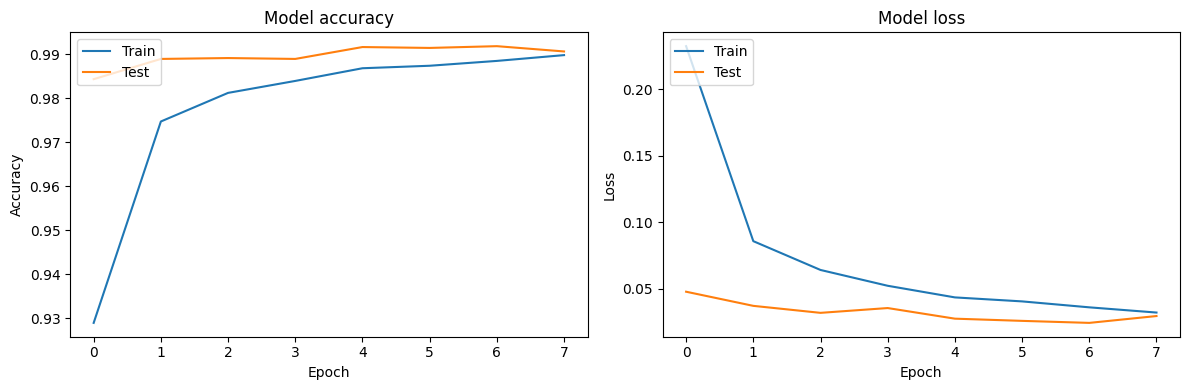

In [5]:
(x_train, y_train), (x_test, y_test) = load_data(img_rows, img_cols, num_classes)
history = model.fit(x_train, y_train, batch_size=128, epochs=8, verbose=1, validation_data=(x_test, y_test))
model.save('mnist_model.h5')

# 精度の学習曲線
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# 損失の学習曲線
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

# 動作確認

313/313 [==============================] - 1s 2ms/step


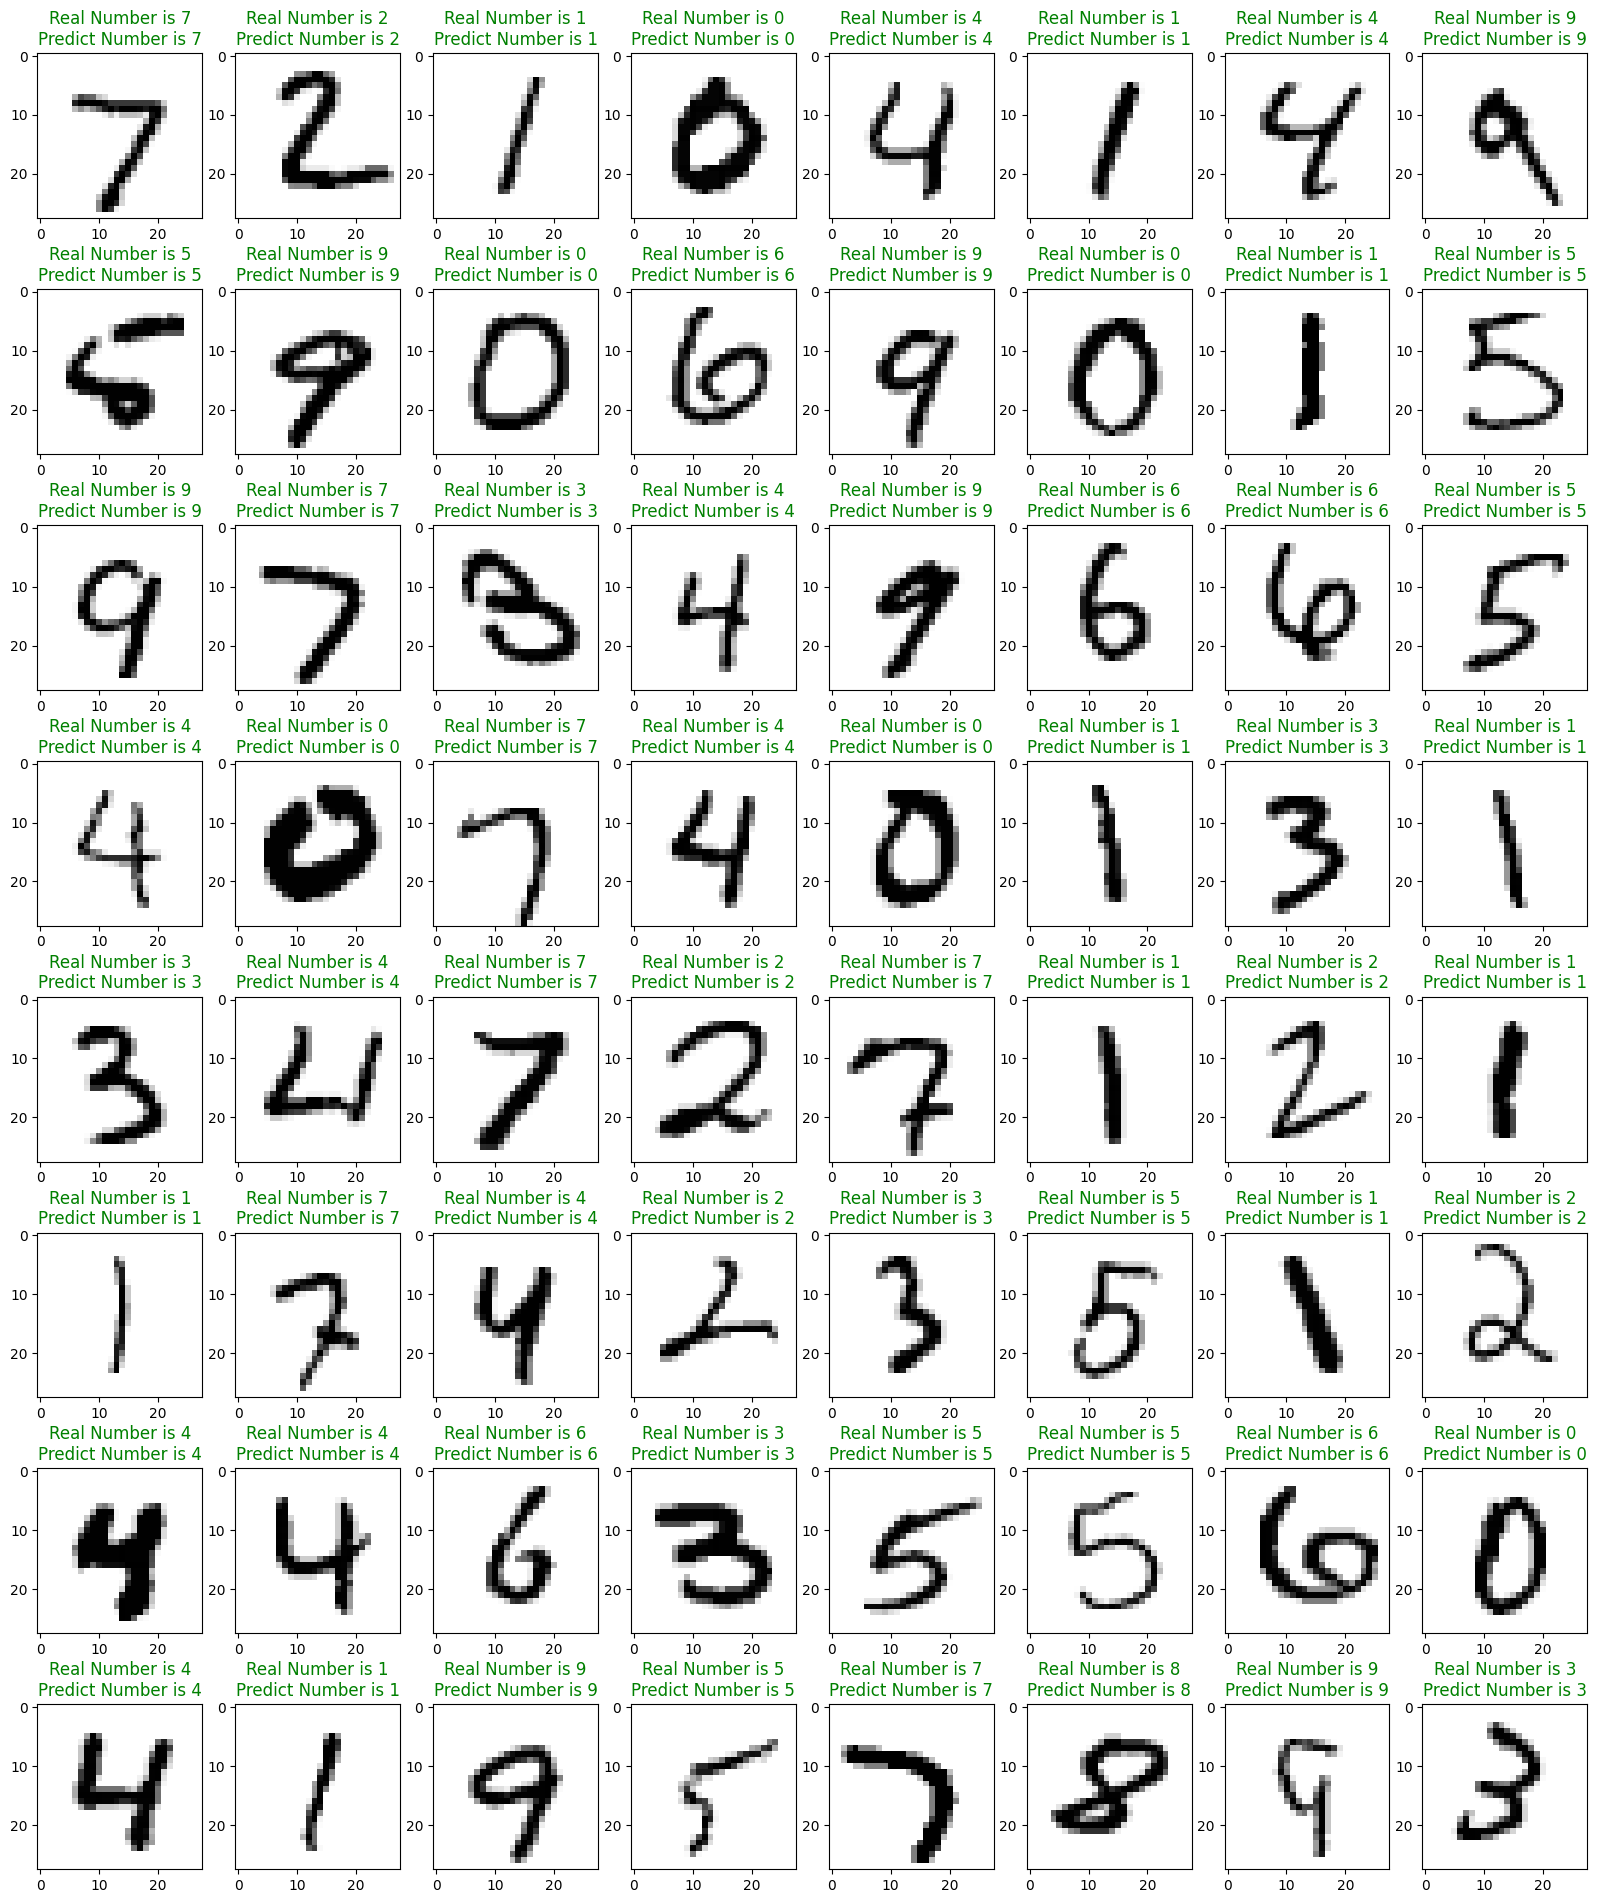

In [6]:
model = load_model('mnist_model.h5')
y_pred = model.predict(x_test)

def plot_pred(y_pred):
    fig, axis = plt.subplots(8, 8, figsize=(20, 24))
    for i, ax in enumerate(axis.flat):
        expected = y_test[i].argmax()
        actual = y_pred[i].argmax()
        ax.imshow(x_test[i], cmap='binary')
        ax.set_title(f"Real Number is {expected}\nPredict Number is {actual}", color=("green" if expected == actual else "red"))
plot_pred(y_pred)

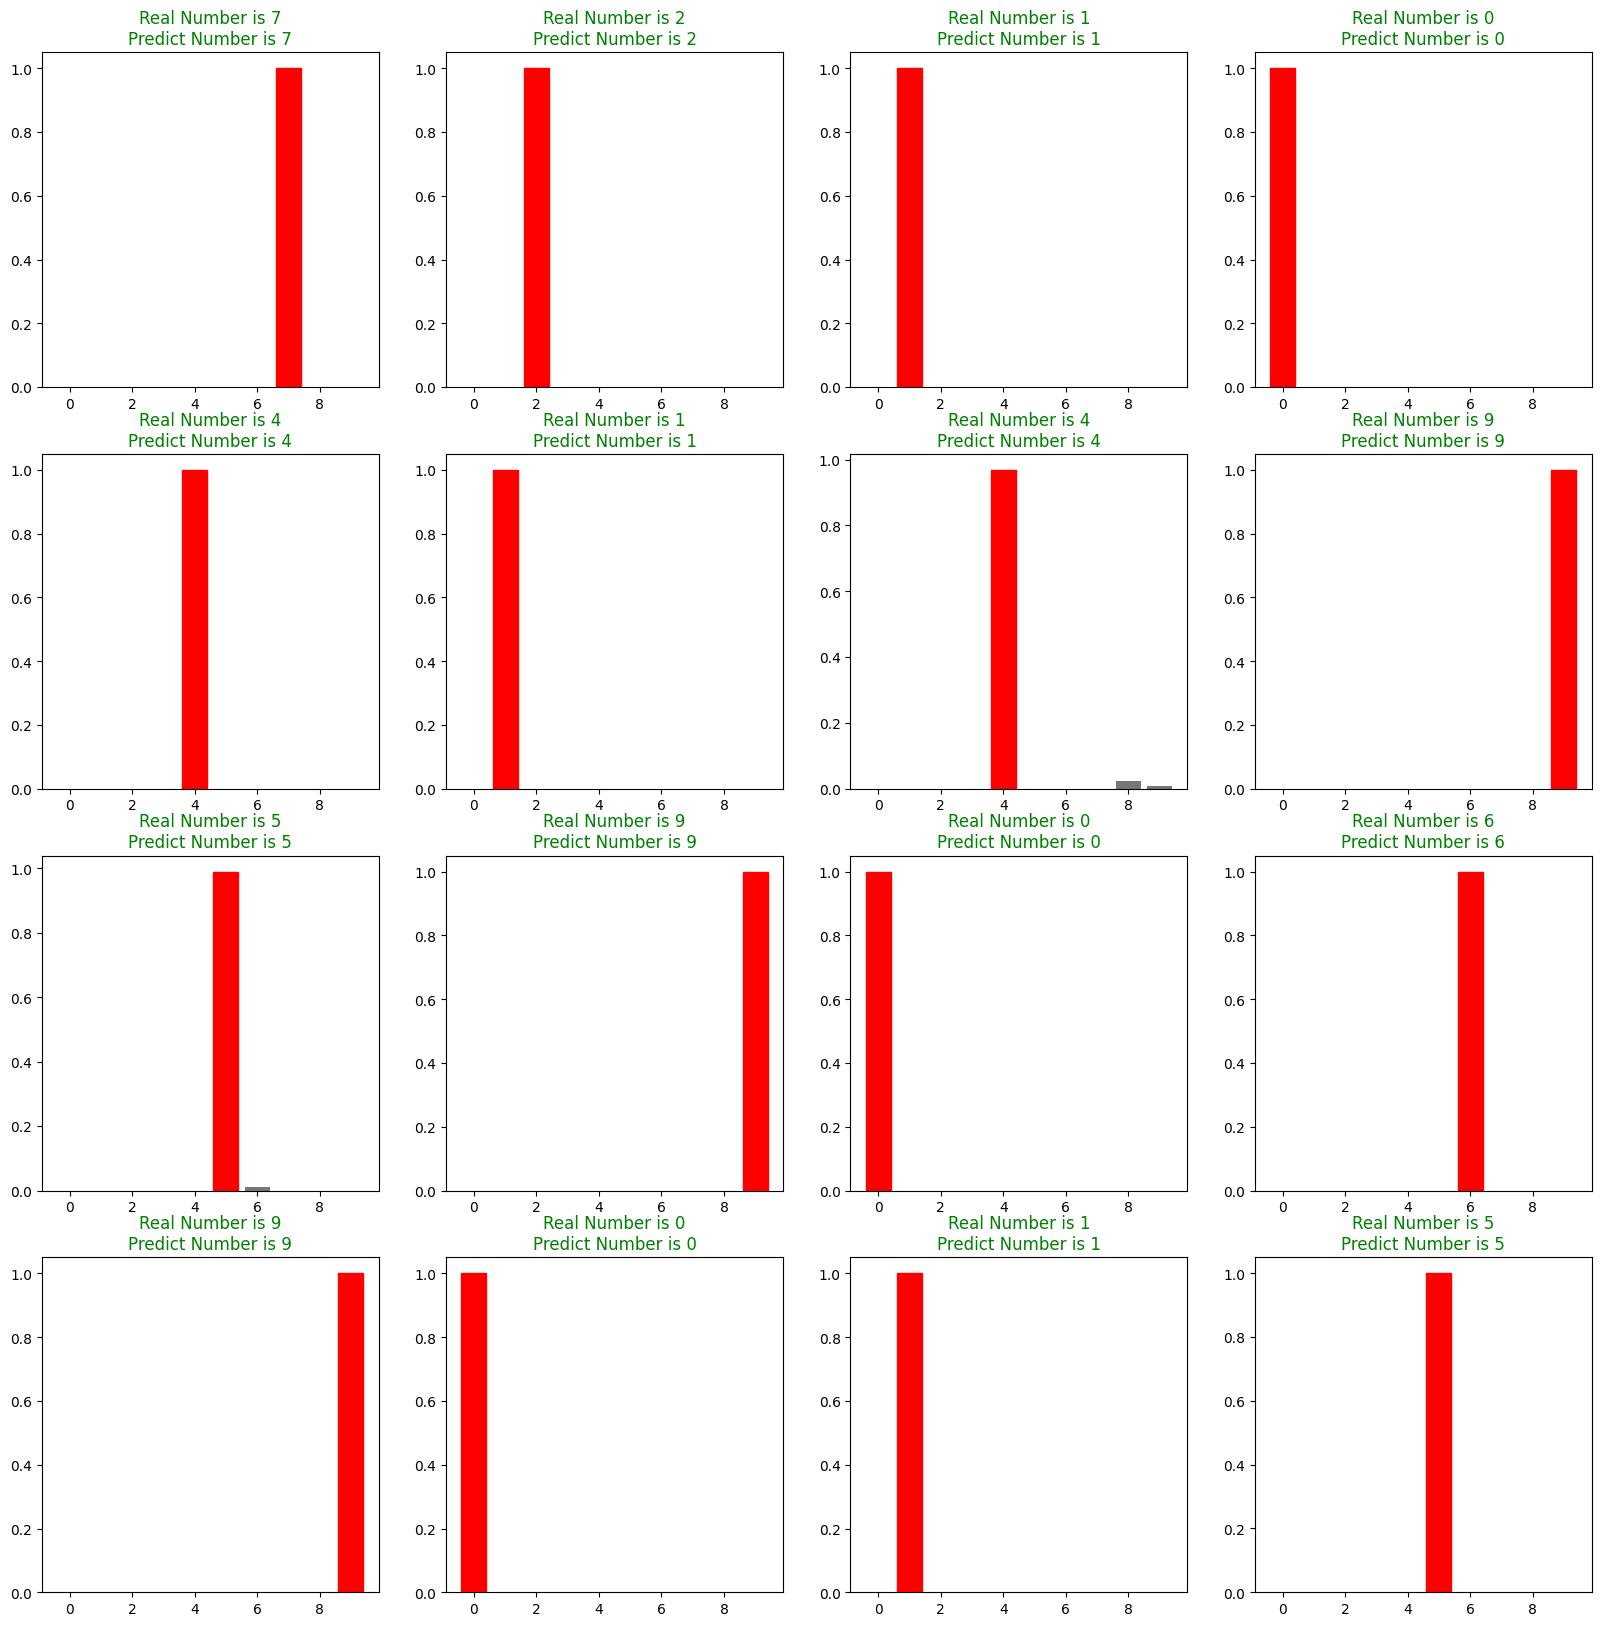

In [7]:
def plot_value_array(y_pred):
    fig, axis = plt.subplots(4, 4, figsize=(20, 20))
    for i, ax in enumerate(axis.flat):
        expected = y_test[i].argmax()
        actual = y_pred[i].argmax()
        thisplot = ax.bar(range(10), y_pred[i], color="#777777")
        thisplot[actual].set_color('red')
        ax.set_title(f"Real Number is {expected}\nPredict Number is {actual}", color=("green" if expected == actual else "red"))

plot_value_array(y_pred)